## BSplines

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_graphics.math.interpolation as inter
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib notebook

## Drawing BSpline bases

In [2]:
# fixed at 3rd degree
def get_bases(u, x, num_elem):
    pos_x = x * num_elem
    pos_spl = tf.cast(tf.math.floor(pos_x),dtype=tf.int32) + tf.constant(1)
    splines = inter.bspline._quadratic(pos_x%1.0)
    if pos_spl%3 == 0:
        pass
    elif pos_spl%3 == 1:
        splines = [splines[2], splines[0], splines[1]]
    else:
        splines = [splines[1], splines[2], splines[0]]
    return splines

<IPython.core.display.Javascript object>


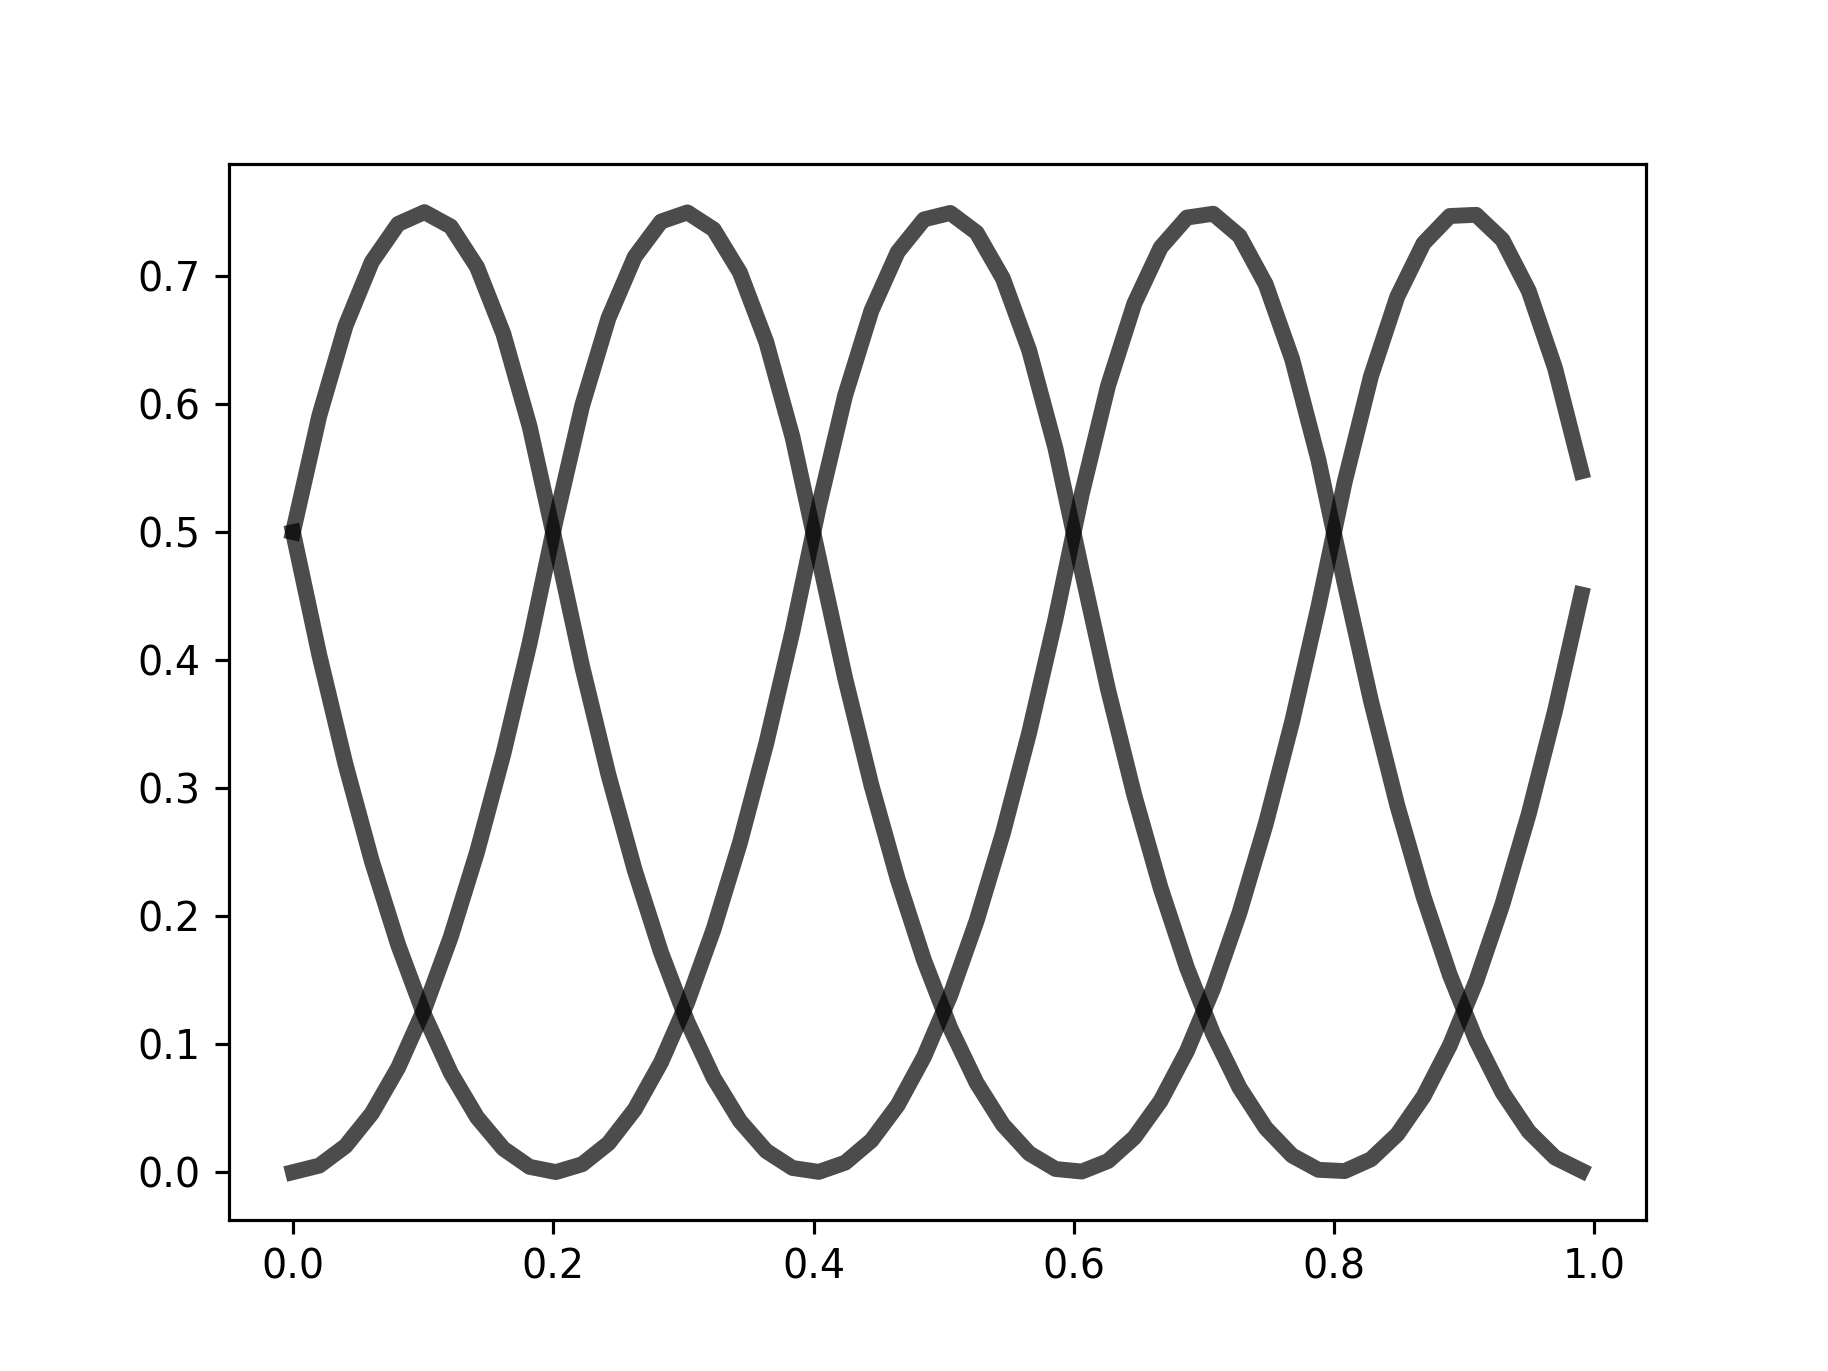

In [3]:
num_elem = tf.constant(5.0)
u = tf.constant([1,1,1,1.2,1,1,1], dtype=tf.float32)

fig, ax = plt.subplots()
xx = np.linspace(0.0, .99, 50)
yy = [get_bases(u, x, num_elem) for x in xx]

ax.plot(xx, yy, 'b-', lw=4, alpha=0.7, color='k')

## Drawing BSplines in 1D

In [4]:
# fixed at 3rd degree
def eval_point_1d(u, x, num_elem):
    pos_x = x * num_elem
    pos_spl = tf.cast(tf.math.floor(pos_x),dtype=tf.int32) + tf.constant(1)
    splines = inter.bspline._quadratic(pos_x%1.0)
    return tf.tensordot(splines, tf.gather(u, tf.range(pos_spl-1,pos_spl+2)), axes=1)

<IPython.core.display.Javascript object>


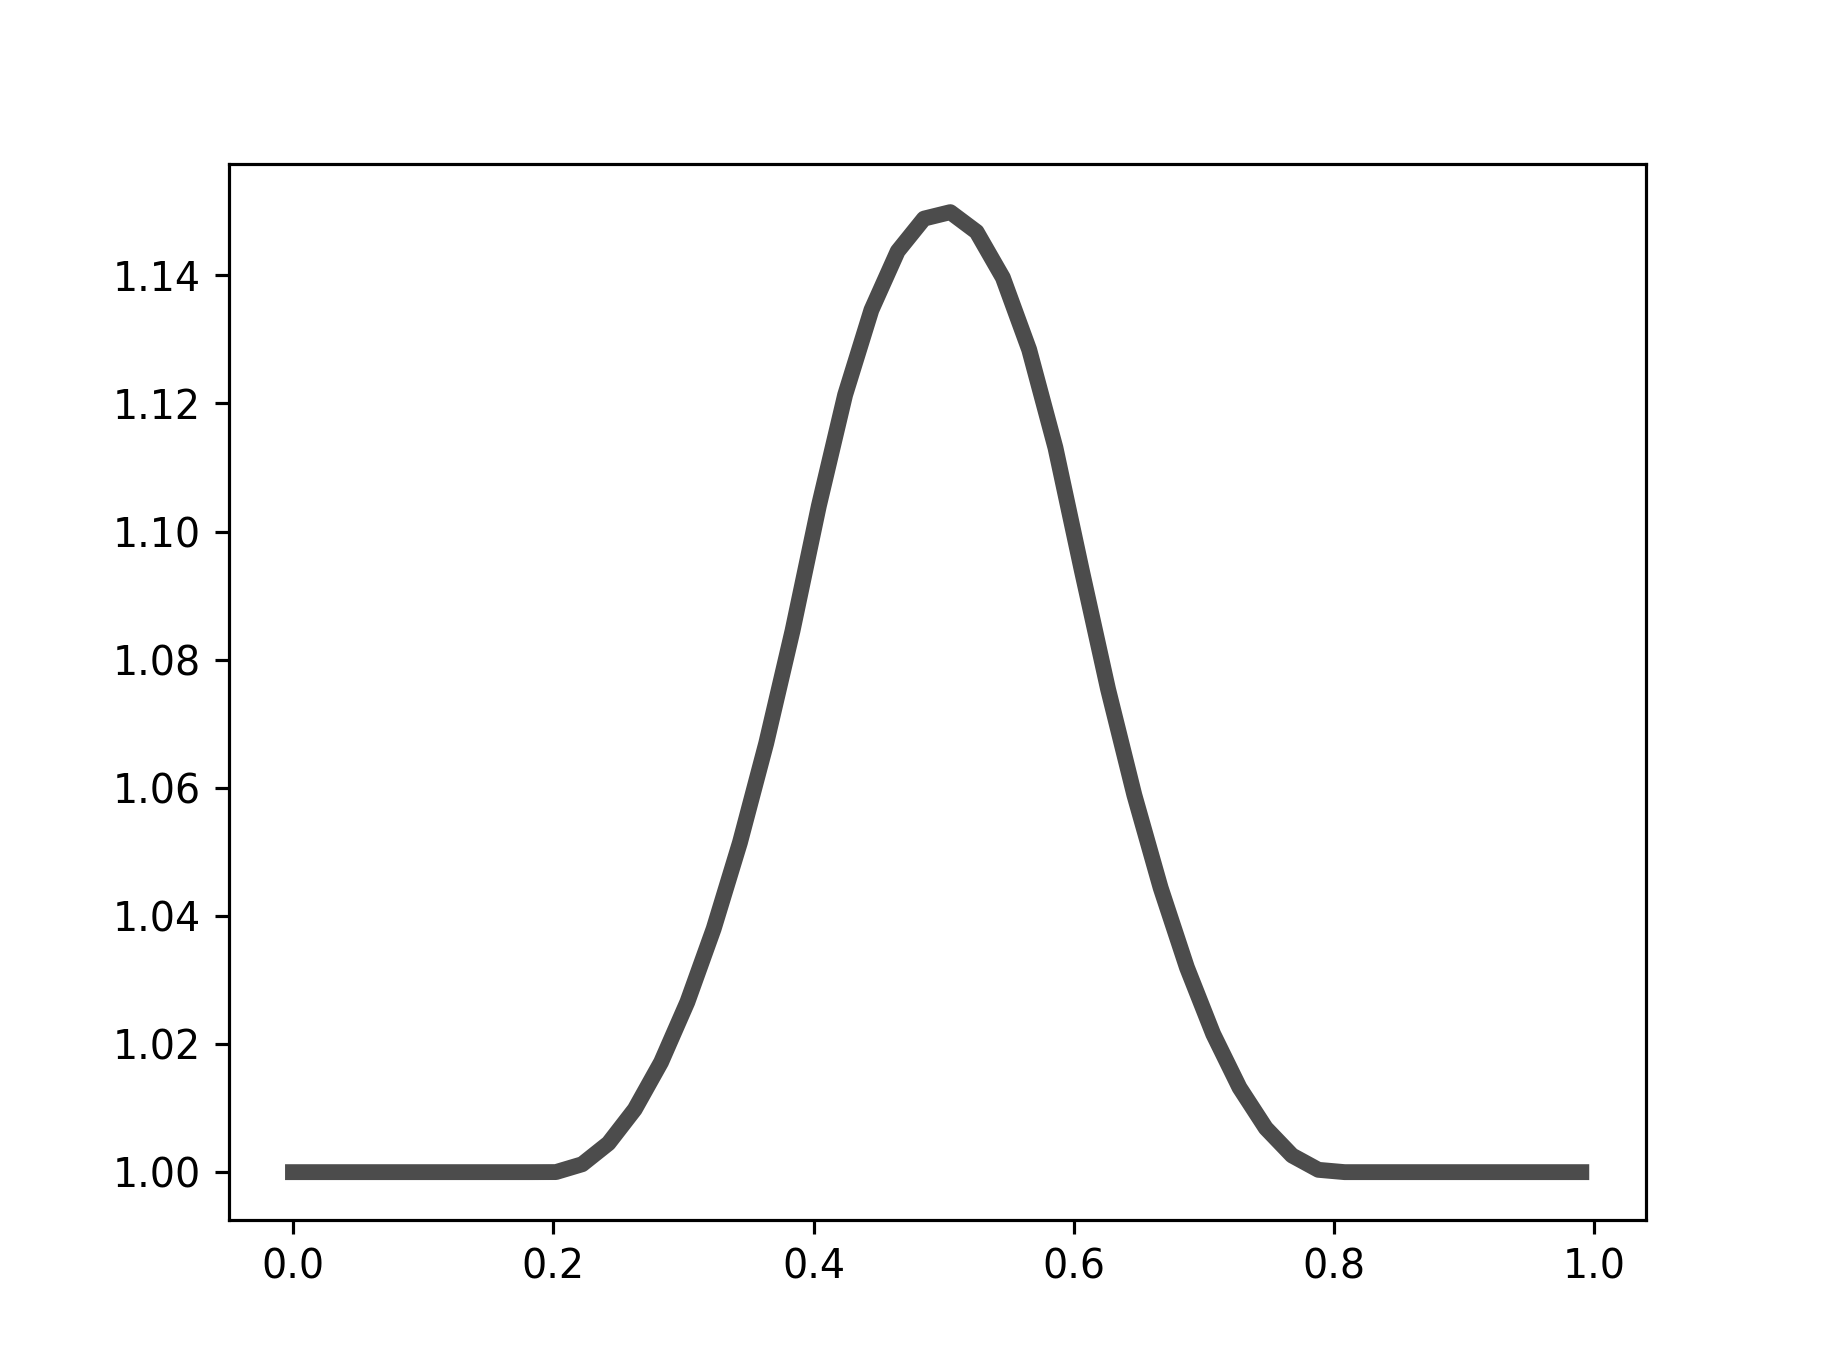

In [5]:
num_elem = tf.constant(5.0)
u = tf.constant([1,1,1,1.2,1,1,1], dtype=tf.float32)

fig, ax = plt.subplots()
xx = np.linspace(0.0, .99, 50)
yy = [eval_point_1d(u, x, num_elem) for x in xx]

ax.plot(xx, yy, 'b-', lw=4, alpha=0.7, color='k')

## Drawing BSplines in 2D

Code below is taken directly from FEM-PINNs prototype implementation

In [7]:
def get_spline(num_elem, x):
    pos_x = x * num_elem
    pos_spl = tf.cast(tf.math.floor(pos_x), dtype=tf.int32) + tf.constant(1)
    pos_spl = tf.cond(pos_spl > num_elem, lambda: num_elem, lambda: pos_spl)
    splines = inter.bspline._quadratic(pos_x%1.0)
    return splines, pos_spl

def eval_point_2d(u, x, y, num_elem, degree):
    splines_x, pos_x = get_spline(num_elem, x)
    splines_y, pos_y = get_spline(num_elem, y)
    X, Y = tf.meshgrid(splines_y, splines_x)
    W = tf.slice(u, [pos_x-1, pos_y-1], [degree,degree])
    return tf.math.reduce_sum(W * X * Y)

<IPython.core.display.Javascript object>


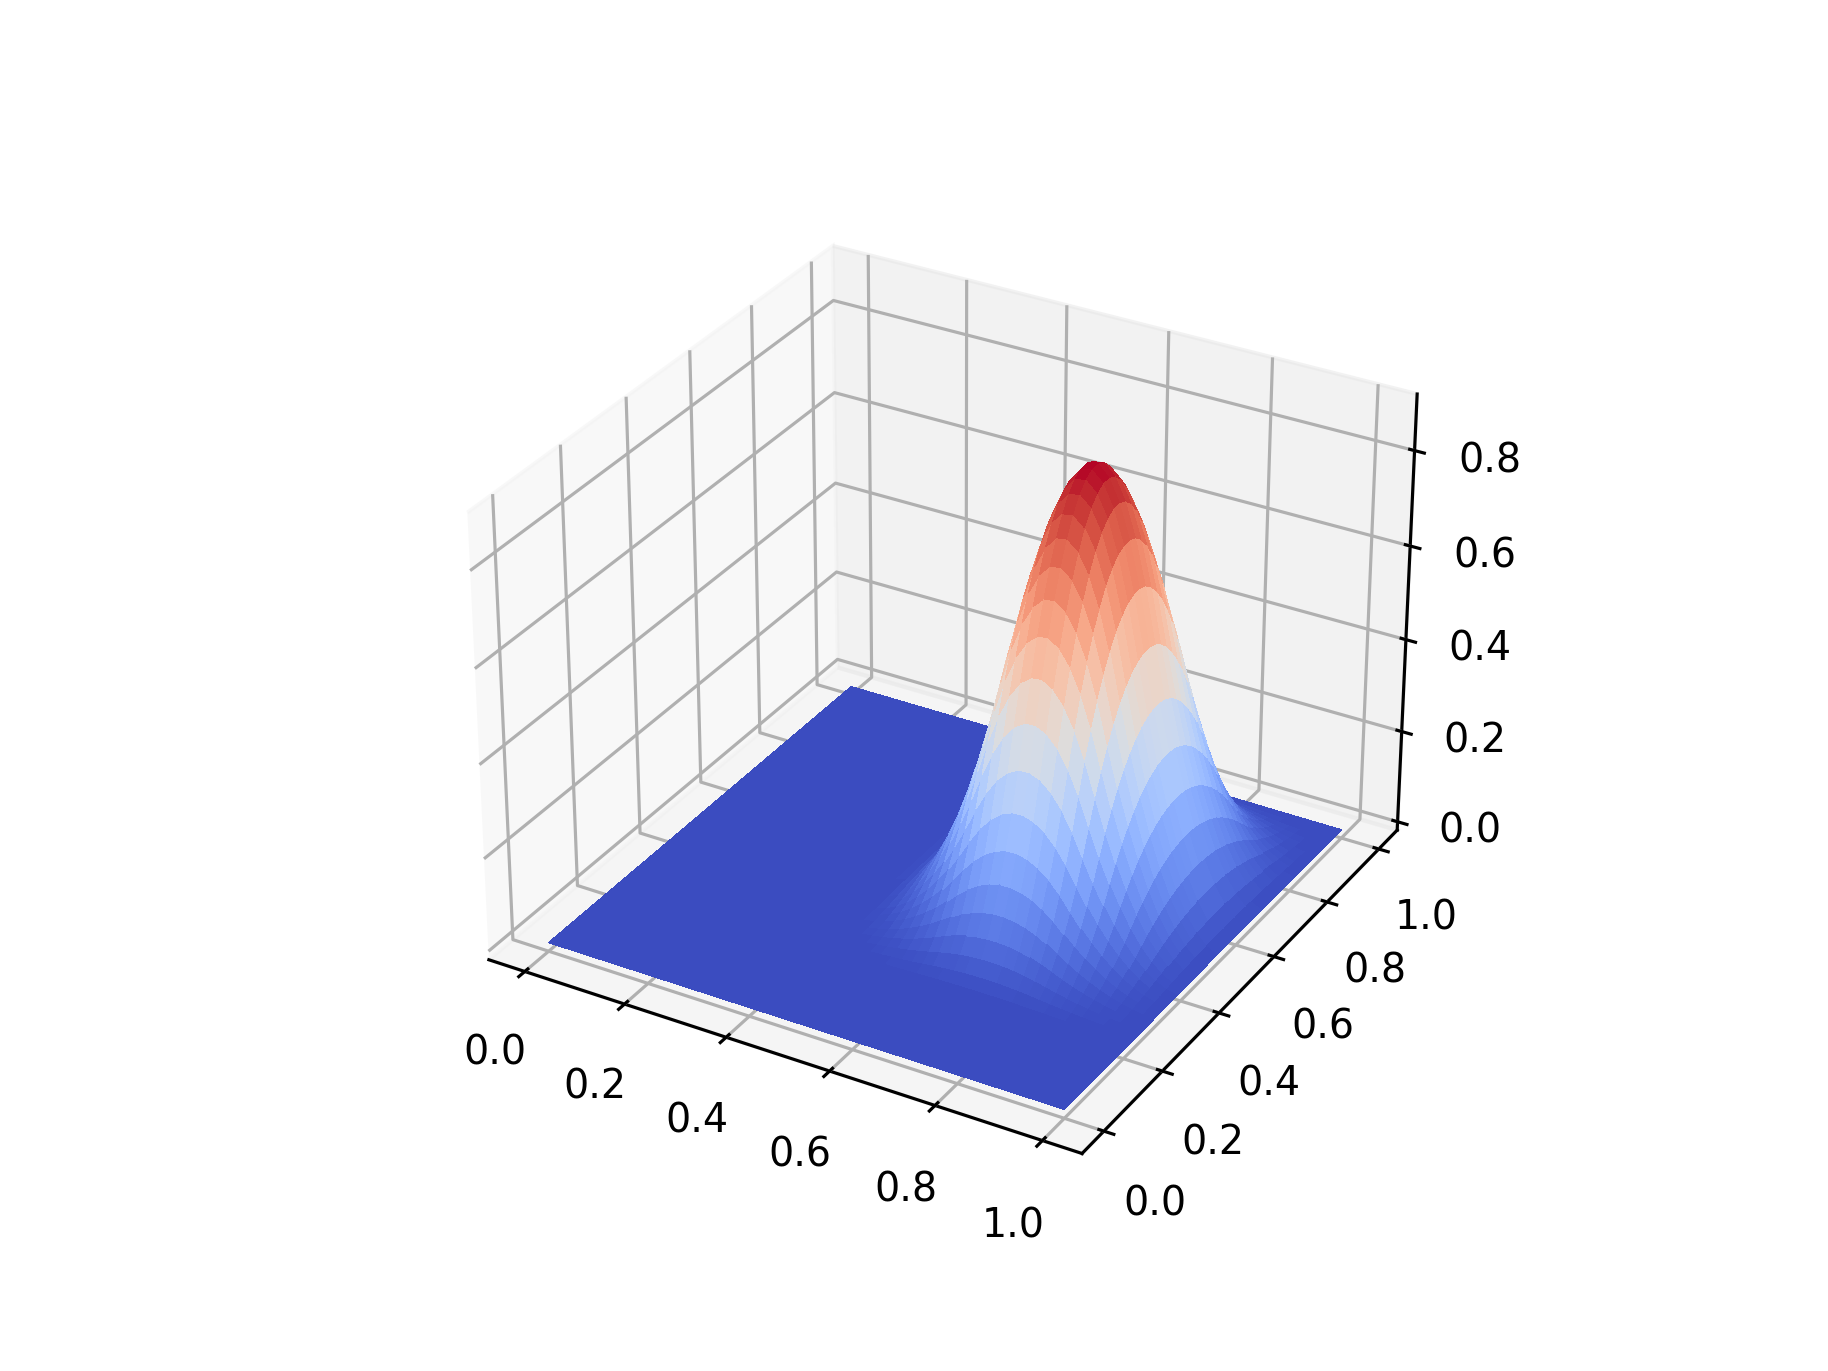

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0.0, 1.0, 50)
Y = np.linspace(0.0, 1.0, 50)
X, Y = np.meshgrid(X, Y)
Z = np.zeros((50, 50))

u = np.array([[0,0,0,0,0,0,0] for i in range(7)],dtype=np.float64)
u[3:5,4:5] = 1.2

for idx_i, i in enumerate(np.linspace(0.0, 0.99, 50)):
    for idx_j, j in enumerate(np.linspace(0.0, 0.99, 50)):
        a = eval_point_2d(u, i, j, 5, 3)
        Z[idx_i, idx_j] = a.numpy()

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)